<a href="https://colab.research.google.com/github/ygcahyono/ds_personal_logging/blob/main/TapTapSend_YogiCahyono_DuplicateDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background


A single individual may attempt to set up multiple user accounts with Taptap Send. This could be an indication that the individual intends to commit fraud, for example by using the same promo code multiple times or by attempting to circumvent restrictions we have placed on their existing account. To prevent this kind of fraud, we would like to identify, **as soon as possible after user account creation**, whether the individual has previously set up a Taptap Send user account. Assume we have the following tables to assist us.

# Task 1

**Task #1:** Write one or more SQL queries in a dialect of your choice to help you identify cases where a single individual has set up multiple user accounts.

## Create Tables using Sqlite3

In [1]:
import sqlite3
import pandas as pd
from datetime import datetime, timedelta

conn = sqlite3.connect(':memory:')
c = conn.cursor()

c.executescript("""
    CREATE TABLE users (
        user_id INTEGER PRIMARY KEY,
        created_at TEXT,
        date_of_birth TEXT,
        first_name TEXT,
        middle_names TEXT,
        last_name TEXT,
        is_blocked INTEGER  -- 0 = not blocked, 1 = blocked
    );

    CREATE TABLE addresses (
        address_id INTEGER PRIMARY KEY,
        created_at TEXT,
        user_id INTEGER,
        street_number TEXT,
        street_name TEXT,
        locality TEXT,
        country TEXT,
        postcode TEXT,
        FOREIGN KEY (user_id) REFERENCES users(user_id)
    );

    CREATE TABLE emails (
        email_id INTEGER PRIMARY KEY,
        created_at TEXT,
        user_id INTEGER,
        email TEXT,
        FOREIGN KEY (user_id) REFERENCES users(user_id)
    );

    CREATE TABLE phones (
        phone_id INTEGER PRIMARY KEY,
        created_at TEXT,
        user_id INTEGER,
        phone_number TEXT,
        country_code TEXT,
        FOREIGN KEY (user_id) REFERENCES users(user_id)
    );
""")

## ERD (Data Modeling) | New

In [2]:
from IPython.display import Image, display
import base64

mermaid_code = """
erDiagram
    users ||--o{ emails : "has"
    users ||--o{ phones : "has"
    users ||--o{ addresses : "has"

    users {
        int user_id PK
        text created_at
        text date_of_birth
        text first_name
        text middle_names
        text last_name
        int is_blocked
    }

    emails {
        int email_id PK
        text created_at
        int user_id FK
        text email
    }

    phones {
        int phone_id PK
        text created_at
        int user_id FK
        text phone_number
        text country_code
    }

    addresses {
        int address_id PK
        text created_at
        int user_id FK
        text street_number
        text street_name
        text locality
        text country
        text postcode
    }
"""

# Encode and display
encoded = base64.b64encode(mermaid_code.encode()).decode()
graph_url = f"https://mermaid.ink/img/{encoded}"
display(Image(url=graph_url))

## Sample Data to show the data

In [3]:
# Insert data with specific detection patterns
c.executescript("""
    -- User 1 & 2: SHARED EMAIL detection
    INSERT INTO users VALUES
        (1, '2024-09-15 10:00:00', '1990-05-15', 'Alice', NULL, 'Brown', 0),
        (2, '2024-09-16 14:00:00', '1988-03-20', 'Bob', 'James', 'Wilson', 0);
    INSERT INTO emails VALUES
        (1, '2024-09-15 10:01:00', 1, 'shared.email@gmail.com'),
        (2, '2024-09-16 14:01:00', 2, 'shared.email@gmail.com');
    INSERT INTO phones VALUES
        (1, '2024-09-15 10:01:30', 1, '7900111111', '+44'),
        (2, '2024-09-16 14:01:30', 2, '7900222222', '+44');
    INSERT INTO addresses VALUES
        (1, '2024-09-15 10:02:00', 1, '10', 'Baker Street', 'London', 'United Kingdom', 'NW1 6XE'),
        (2, '2024-09-16 14:02:00', 2, '20', 'King Road', 'Manchester', 'United Kingdom', 'M1 1AA');

    -- User 3 & 4: SHARED PHONE detection
    INSERT INTO users VALUES
        (3, '2024-08-10 09:00:00', '1992-07-10', 'Charlie', NULL, 'Davis', 0),
        (4, '2024-08-11 11:00:00', '1985-11-25', 'Diana', 'Rose', 'Evans', 0);
    INSERT INTO emails VALUES
        (3, '2024-08-10 09:01:00', 3, 'charlie.davis@yahoo.com'),
        (4, '2024-08-11 11:01:00', 4, 'diana.evans@outlook.com');
    INSERT INTO phones VALUES
        (3, '2024-08-10 09:01:30', 3, '7933444444', '+44'),
        (4, '2024-08-11 11:01:30', 4, '7933444444', '+44');
    INSERT INTO addresses VALUES
        (3, '2024-08-10 09:02:00', 3, '30', 'Queen Avenue', 'Birmingham', 'United Kingdom', 'B1 1AA'),
        (4, '2024-08-11 11:02:00', 4, '40', 'Prince Street', 'Leeds', 'United Kingdom', 'LS1 1AA');

    -- User 5 & 6: SHARED ADDRESS detection
    INSERT INTO users VALUES
        (5, '2024-07-01 12:00:00', '1995-02-14', 'Emma', 'Kate', 'Foster', 0),
        (6, '2024-07-02 13:00:00', '1993-09-18', 'Frank', NULL, 'Green', 0);
    INSERT INTO emails VALUES
        (5, '2024-07-01 12:01:00', 5, 'emma.foster@gmail.com'),
        (6, '2024-07-02 13:01:00', 6, 'frank.green@gmail.com');
    INSERT INTO phones VALUES
        (5, '2024-07-01 12:01:30', 5, '7955666666', '+44'),
        (6, '2024-07-02 13:01:30', 6, '7955777777', '+44');
    INSERT INTO addresses VALUES
        (5, '2024-07-01 12:02:00', 5, '50', 'High Street', 'Bristol', 'United Kingdom', 'BS1 5TR'),
        (6, '2024-07-02 13:02:00', 6, '50', 'High Street', 'Bristol', 'United Kingdom', 'BS1 5TR');

    -- User 7 & 8: DOB + NAME MATCH detection
    INSERT INTO users VALUES
        (7, '2024-06-20 15:00:00', '1991-12-05', 'George', 'Michael', 'Harris', 0),
        (8, '2024-06-21 16:00:00', '1991-12-05', 'George', 'M', 'Harris', 0);
    INSERT INTO emails VALUES
        (7, '2024-06-20 15:01:00', 7, 'george.h.1991@gmail.com'),
        (8, '2024-06-21 16:01:00', 8, 'g.harris91@yahoo.com');
    INSERT INTO phones VALUES
        (7, '2024-06-20 15:01:30', 7, '7977888888', '+44'),
        (8, '2024-06-21 16:01:30', 8, '7977999999', '+44');
    INSERT INTO addresses VALUES
        (7, '2024-06-20 15:02:00', 7, '70', 'Church Lane', 'Liverpool', 'United Kingdom', 'L1 1AA'),
        (8, '2024-06-21 16:02:00', 8, '80', 'Market Square', 'Newcastle', 'United Kingdom', 'NE1 1AA');

    -- User 9 & 10: CLEAN USERS (no matches)
    INSERT INTO users VALUES
        (9, '2024-05-10 10:00:00', '1987-04-22', 'Isabel', NULL, 'Jones', 0),
        (10, '2024-05-11 11:00:00', '1994-08-30', 'Jack', 'Thomas', 'King', 0);
    INSERT INTO emails VALUES
        (9, '2024-05-10 10:01:00', 9, 'isabel.jones@gmail.com'),
        (10, '2024-05-11 11:01:00', 10, 'jack.king@outlook.com');
    INSERT INTO phones VALUES
        (9, '2024-05-10 10:01:30', 9, '7911111111', '+44'),
        (10, '2024-05-11 11:01:30', 10, '7922222222', '+44');
    INSERT INTO addresses VALUES
        (9, '2024-05-10 10:02:00', 9, '90', 'Park Road', 'Edinburgh', 'United Kingdom', 'EH1 1AA'),
        (10, '2024-05-11 11:02:00', 10, '100', 'Castle Street', 'Glasgow', 'United Kingdom', 'G1 1AA');

    -- User 11 & 12: DOB + NAME + ADDRESS detection (fulfills new CTE condition)
    INSERT INTO users VALUES
        (11, '2024-10-01 08:00:00', '1989-06-18', 'Sarah', 'Jane', 'Thompson', 0),
        (12, '2024-10-01 09:30:00', '1989-06-18', 'Sarah', 'J', 'Thompson', 0);

    INSERT INTO emails VALUES
        (11, '2024-10-01 08:01:00', 11, 'sarah.thompson89@gmail.com'),
        (12, '2024-10-01 09:31:00', 12, 'sthompson.work@yahoo.com');

    INSERT INTO phones VALUES
        (11, '2024-10-01 08:01:30', 11, '7944556677', '+44'),
        (12, '2024-10-01 09:31:30', 12, '7944889900', '+44');

    INSERT INTO addresses VALUES
        (11, '2024-10-01 08:02:00', 11, '15', 'Station Street', 'Cambridge', 'United Kingdom', 'CB1 1AA'),
        (12, '2024-10-01 09:32:00', 12, '22', 'Station Street', 'Cambridge', 'United Kingdom', 'CB1 1AA');
        -- Same locality (Cambridge) + Same postcode (CB1 1AA) + Same DOB + Same Name = 90 risk score

""")

conn.commit()

In [4]:

print("📊 Total records:")
print(f"   - Users: {pd.read_sql_query('SELECT COUNT(*) as count FROM users', conn)['count'][0]}")
print(f"   - Emails: {pd.read_sql_query('SELECT COUNT(*) as count FROM emails', conn)['count'][0]}")
print(f"   - Phones: {pd.read_sql_query('SELECT COUNT(*) as count FROM phones', conn)['count'][0]}")
print(f"   - Addresses: {pd.read_sql_query('SELECT COUNT(*) as count FROM addresses', conn)['count'][0]}")

📊 Total records:
   - Users: 12
   - Emails: 12
   - Phones: 12
   - Addresses: 12


## Simple SQL Detection Logic

**Task #1** Simple SQL detection, I am creating four identification

1. Shared Email Detection (Risk Score: 100)
This is our strongest fraud signal. It's pretty straightforward - if two different user accounts are using the exact same email address, that's a massive red flag. There's really no legitimate reason for two separate people to share an email for financial services. We give this the highest risk score (100 points) because it almost always indicates the same person trying to create multiple accounts, likely to abuse promotions, bypass transaction limits, or evade previous blocks.

2. Shared Phone Number Detection (Risk Score: 70)
When multiple accounts use the identical phone number (including country code), it's a strong indicator of duplicate accounts. We score this at 70 points because while it's suspicious, there are occasional edge cases - like family members sharing a work phone or household landline. That said, in remittance services where phone verification is critical for security, shared numbers deserve serious scrutiny.

3. Exact Address Match Detection (Risk Score: 50)
This one catches accounts that share the complete physical address - same house number, street name, city, and postcode. We're more conservative here with 50 points because there are legitimate reasons for this: family members living together, roommates, or couples. It becomes much more concerning when combined with other signals, but on its own, it's not definitive proof of fraud.

4. DOB + Name + Location Detection (Risk Score: 50)
This flags accounts with identical dates of birth and matching first/last names. We set this at 50 points because while it's suspicious, it's not definitive on its own. Common names like "Sarah Johnson" or "Mohammed Ali" exist in large numbers, and sharing a birthday isn't as rare as we'd think, Especially in diverse user bases. This signal becomes much more valuable when combined with other detection methods (like shared phone or email), but alone it could easily be coincidental. We use it as a supporting indicator rather than a standalone fraud proof.

In [5]:
results = pd.read_sql_query("""
    WITH
        email_based_detection AS (

            SELECT
                e1.user_id,
                e1.email,
                'Shared Email' as detection_method,
                100 as risk_score,
                COUNT(DISTINCT e2.user_id) as linked_accounts
            FROM emails e1
            JOIN emails e2 ON e1.email = e2.email
                AND e1.user_id != e2.user_id
            GROUP BY e1.user_id, e1.email

        ),

        phone_number_based_detection AS (

            SELECT
                p1.user_id,
                p1.country_code || p1.phone_number as full_phone,
                'Shared Phone' as detection_method,
                70 as risk_score,
                COUNT(DISTINCT p2.user_id) as linked_accounts,
                GROUP_CONCAT(DISTINCT p2.user_id) as linked_user_ids
            FROM phones p1
            JOIN phones p2 ON p1.phone_number = p2.phone_number
                AND p1.country_code = p2.country_code
                AND p1.user_id != p2.user_id
            GROUP BY p1.user_id, p1.phone_number, p1.country_code

        ),

        exact_match_address_based_detection AS (

            SELECT
                a1.user_id,
                a1.street_number || ' ' || a1.street_name || ', ' || a1.locality || ' ' || a1.postcode as full_address,
                'Shared Address' as detection_method,
                50 as risk_score,
                COUNT(DISTINCT a2.user_id) as linked_accounts,
                GROUP_CONCAT(DISTINCT a2.user_id) as linked_user_ids
            FROM addresses a1
            JOIN addresses a2 ON
                a1.street_name = a2.street_name
                AND a1.locality = a2.locality
                AND a1.postcode = a2.postcode
                AND a1.country = a2.country
                AND a1.user_id != a2.user_id
            GROUP BY a1.user_id, a1.street_number, a1.street_name,
                    a1.locality, a1.postcode, a1.country

        ),

        dob_name_based_detection AS (

            SELECT
                u1.user_id,
                u1.date_of_birth || ' | ' || u1.first_name || ' ' || u1.last_name as identifier,
                'DOB + Name Match' as detection_method,
                50 as risk_score,
                COUNT(DISTINCT u2.user_id) as linked_accounts,
                GROUP_CONCAT(DISTINCT u2.user_id) as linked_user_ids
            FROM users u1
            JOIN users u2 ON
                u1.date_of_birth = u2.date_of_birth
                AND (
                    -- Match if first name AND last name are the same
                    (LOWER(u1.first_name) = LOWER(u2.first_name)
                    AND LOWER(u1.last_name) = LOWER(u2.last_name))
                )
                AND u1.user_id != u2.user_id
            GROUP BY u1.user_id, u1.date_of_birth, u1.first_name, u1.last_name

        )

        SELECT
            u.user_id
            ,CASE WHEN em.user_id IS NOT NULL THEN em.risk_score ELSE NULL END as email_based_detection_risk_score
            ,CASE WHEN ph.user_id IS NOT NULL THEN ph.risk_score ELSE NULL END as phone_number_based_detection_risk_score
            ,CASE WHEN ex.user_id IS NOT NULL THEN ex.risk_score ELSE NULL END as exact_match_address_based_detection_risk_score
            ,CASE WHEN dob.user_id IS NOT NULL THEN dob.risk_score ELSE NULL END as dob_name_based_detection_risk_score
            ,COALESCE(em.risk_score,0) + COALESCE(ph.risk_score,0) + COALESCE(ex.risk_score,0) + COALESCE(dob.risk_score,0) AS total_score
        FROM users u
        LEFT JOIN email_based_detection em ON u.user_id = em.user_id
        LEFT JOIN phone_number_based_detection ph ON u.user_id = ph.user_id
        LEFT JOIN exact_match_address_based_detection ex ON u.user_id = ex.user_id
        LEFT JOIN dob_name_based_detection dob ON u.user_id = dob.user_id
""", conn)

In [6]:
results

,user_id,email_based_detection_risk_score,phone_number_based_detection_risk_score,exact_match_address_based_detection_risk_score,dob_name_based_detection_risk_score,total_score
0,1,100.0,NaN,NaN,NaN,100
1,2,100.0,NaN,NaN,NaN,100
2,3,NaN,70.0,NaN,NaN,70
3,4,NaN,70.0,NaN,NaN,70
4,5,NaN,NaN,50.0,NaN,50
5,6,NaN,NaN,50.0,NaN,50
6,7,NaN,NaN,NaN,50.0,50
7,8,NaN,NaN,NaN,50.0,50
8,9,NaN,NaN,NaN,NaN,0
9,10,NaN,NaN,NaN,NaN,0


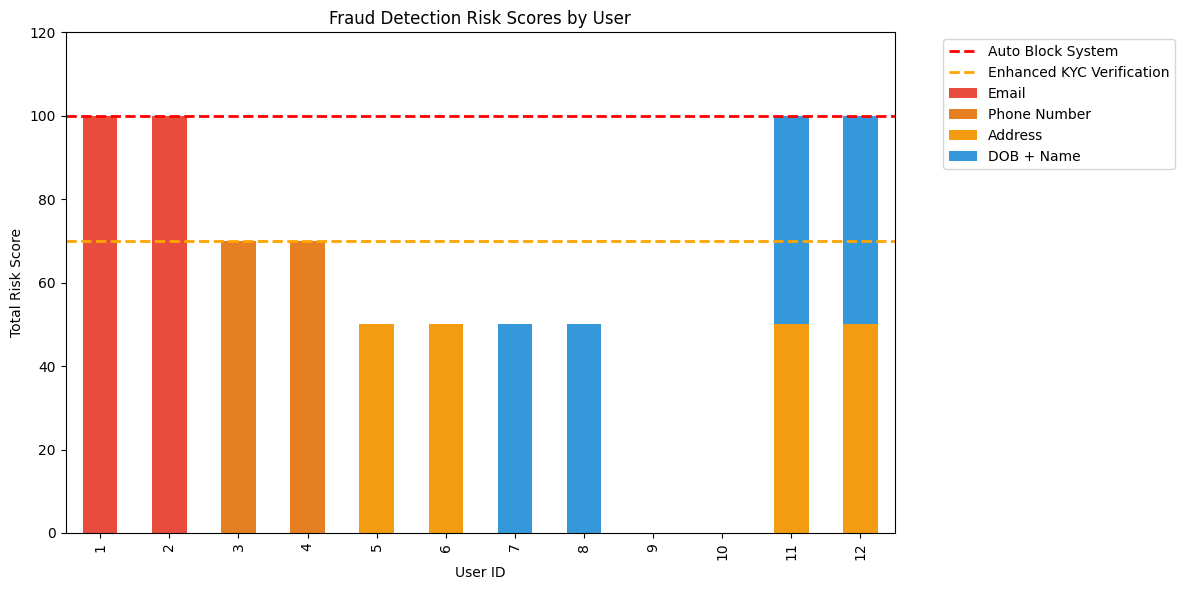

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data
df_viz = results.fillna(0)

fig, ax = plt.subplots(figsize=(12, 6))

# Stacked bar chart
df_viz.plot(
    x='user_id',
    y=['email_based_detection_risk_score',
       'phone_number_based_detection_risk_score',
       'exact_match_address_based_detection_risk_score',
       'dob_name_based_detection_risk_score'],
    kind='bar',
    stacked=True,
    ax=ax,
    color=['#e74c3c', '#e67e22', '#f39c12', '#3498db']
)

# Add threshold lines
ax.axhline(y=100, color='red', linestyle='--', linewidth=2, label='Critical (≥100)')
ax.axhline(y=70, color='orange', linestyle='--', linewidth=2, label='High Risk (70-99)')

ax.set_xlabel('User ID')
ax.set_ylabel('Total Risk Score')
ax.set_title('Fraud Detection Risk Scores by User')
ax.legend(labels=['Auto Block System', 'Enhanced KYC Verification', 'Email', 'Phone Number',
                  'Address', 'DOB + Name'],
          bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim(0, 120)

plt.tight_layout()
plt.show()

## **Detection Results Analysis**


### Critical Risk Accounts (≥100 points) - Immediate Block:

- Users 1 & 2: Shared email (100 pts each) - Same person using identical email address across two accounts.

- Users 11 & 12: Multiple signals (100 pts each) - Shared address + DOB/name match. Sophisticated fraud attempt with coordinated identity data

### High Risk Accounts (70-99 points) - Manual Review Required:

- Users 3 & 4: Shared phone number (80 pts each) - Could be legitimate (family/work) but suspicious in remittance context where phone is primary verification method

### Medium Risk Accounts (50-69 points) - Monitor Only:

- User 5 & 6: Shared address (50 pts) - Likely roommates or family members, different emails/phones suggest legitimate separate users

- Users 7 & 8: DOB + name match (50 pts) - Possible coincidence with common names, lacks supporting fraud signals

### Clean Accounts (0 points):

- Users 9 & 10: No matches detected

## Key Findings:

1. Multiple detection signals combining to ≥100 points represent highest confidence fraud (users 11-12).
2. Fraud threshold at ≥70 points identifies 6 accounts (50%) as potentially fraudulent.
3. Single low-scoring signals (50 pts) don't warrant blocking. They need additional context.
4. The scoring system successfully separates definitive fraud from edge cases requiring human judgment.

Recommended Actions:

- Auto-block: ≥100 points (users 1, 2, 11, 12)
- Enhanced KYC verification: 70-99 points (users 3, 4)
- Passive monitoring: 50-69 points (users 5, 6, 7, 8)

# Task 2 & Task 3

**Task #2:**  Describe how you would incorporate these SQL queries into a business process to prevent individuals from using multiple user accounts to commit fraud.

**Task #3:** If you have time, outline how you could use a machine learning or rule-based approach for improved detection.

To prevent the creation of multiple accounts under the same individual. We should apply the four detection queries **before** account activation and then check the total risk scores for each of the new account:

**Rule Based Method:**

- ≥100 points: Block registration immediately, show "Account already exists"
- 70-99 points: Require additional verification (selfie + ID upload)
- < 70 points: Allow registration, flag for monitoring

**Manual Review Workflow (70-99 points):**
1. Queue account for fraud analyst review
2. Manual verificator compares new selfie/ID against linked account's documents
3. Decision:
   - **Match found:** Block registration, add to blocklist
   - **Different person:** Approve account, document as false positive
   - **Inconclusive:** Request additional verification or escalate

Implementation:

- API endpoint runs SQL during signup
- Response time: < 2 seconds
- Log all checks for audit trail